In [1]:
import random

In [2]:
random_seed = 10
random.seed(random_seed)

In [3]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np
np.random.seed(10)
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

In [6]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Topic Models/combined_BERT.csv')
#df.head(5)

## Preprocessing

In [7]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

## Embedding

In [8]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
        #adding this to see the shape of the embedding
        logging.info(f"Embedding shape for input: {emb.shape}")
        return emb
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/80 [00:00<?, ?it/s]

In [9]:
# embeddings are computed and saved in df
embedding_example = df.loc[df['embedding'].notnull(), 'embedding'].iloc[0]

print(type(embedding_example))  # we want a numpy array here
print(embedding_example.shape)  # This will tell us the embedding dimensions :)

<class 'numpy.ndarray'>
(384,)


## Model Creation

In [10]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [11]:
%pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.3 MB/s eta 0:00:00


In [12]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [13]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=6, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [14]:
## bertopic.py ##
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize UMAP model with random_state for reproducibility
umap_model = UMAP(random_state=random_seed)

# Initialize Clustering Model (Fuzzy C-Means)
cluster_model = FuzzyCMeansModel(n_clusters= 6)

# Initialize BERTopic model with the UMAP model and the custom clustering model
# random_state is removed as it's not supported in this BERTopic version
bertopic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, store the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('land', 0.10507705546633472), ('communities', 0.03911281065090646), ('plasma', 0.03362215130648404), ('local', 0.02527532314187803), ('rights', 0.024706533450187616), ('hcv', 0.02283377663185127), ('process', 0.022461995763315545), ('complaint', 0.02128933736826606), ('plantation', 0.02103045432804878), ('dispute', 0.020521879361215512)], 1: [('deforestation', 0.07775562435375379), ('rapid', 0.07267742078557768), ('earth', 0.06832948904466021), ('mighty', 0.06754132645950152), ('response', 0.06741043729572878), ('concession', 0.06235653904513998), ('ha', 0.061853124072832055), ('gar', 0.054502055685908365), ('indications', 0.04764356572361759), ('cleared', 0.04333523140489165)], 2: [('hershey', 0.05809197694266444), ('peatland', 0.05437762812362992), ('deforestation', 0.051268357738324465), ('development', 0.04950734196646925), ('suppliers', 0.0493447051985616), ('supplier', 0.03880697854989441), ('grievance', 0.03824033007640586), ('mighty', 0.0351

In [15]:
print(bertopic_model.get_topic_info())

   Topic  Count                                          Name  \
0      0     86               0_land_communities_plasma_local   
1      1     83            1_deforestation_rapid_earth_mighty   
2      2     80  2_hershey_peatland_deforestation_development   
3      3     74      3_cargill_grievance_direct_deforestation   
4      4     63                 4_area_forest_plantation_mill   
5      5     60                 5_workers_labour_rights_union   

                                      Representation  \
0  [land, communities, plasma, local, rights, hcv...   
1  [deforestation, rapid, earth, mighty, response...   
2  [hershey, peatland, deforestation, development...   
3  [cargill, grievance, direct, deforestation, su...   
4  [area, forest, plantation, mill, land, river, ...   
5  [workers, labour, rights, union, labor, employ...   

                                 Representative_Docs  
0  [clearedand planted land submitting new planti...  
1  [mighty earth rapid response 2 carryin

## Raw Output

In [16]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['land', 'communities', 'plasma', 'local', 'rights', 'hcv', 'process', 'complaint', 'plantation', 'dispute']
Topic 1 Representation: ['deforestation', 'rapid', 'earth', 'mighty', 'response', 'concession', 'ha', 'gar', 'indications', 'cleared']
Topic 2 Representation: ['hershey', 'peatland', 'deforestation', 'development', 'suppliers', 'supplier', 'grievance', 'mighty', 'earth', 'forest']
Topic 3 Representation: ['cargill', 'grievance', 'direct', 'deforestation', 'supplier', 'filed', 'allegations', 'suppliers', 'sourcing', 'raised']
Topic 4 Representation: ['area', 'forest', 'plantation', 'mill', 'land', 'river', 'plantations', '2013', 'gar', 'principle']
Topic 5 Representation: ['workers', 'labour', 'rights', 'union', 'labor', 'employment', 'members', 'forced', 'working', 'conditions']


In [17]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [18]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [19]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dom_topic_num = row['topic']
        dom_topic_prob = round(row['probs'], 2)
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {}
        for n in range(n_topics):
            topic_dist[f'Topic_{n}'] = row[f'Topic_{n}']

        topic_binary = {f"Topic_{i}": 0 for i in range(n_topics)}

        shared_perc = 0.0
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)

        is_outlier = False
        itr = 0

        # Use the membership probabilities from the row if available
        for i in range(n_topics):
            topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'], 2)

            while (shared_perc < 0.5):
                # Get Topic Number and Topic Percentage
                topic_num, topic_perc = sorted_doc[itr]
                topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
                shared_perc += topic_perc
                topic_binary[f"Topic_{topic_num}"] = 1  # Multi-Label Binary Classifcation
                itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        # Keywords
        keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])


        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [20]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)


dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
dominant_topic_df

,Document_Num,Dominant_Topic,Topic_%_Contrib,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc
0,0,3,0.53,"hershey, peatland, deforestation, development,...",non compliant products amanah saham pahang ber...,False,1,0,0,0,1,0,0,0.05,0.08,0.06,0.53,0.09,0.19
1,1,0,1.00,"workers, labour, rights, union, labor, employm...",complaint matter public interest taken complai...,False,1,1,0,0,0,0,0,1.00,0.00,0.00,0.00,0.00,0.00
2,2,5,0.83,"cargill, grievance, direct, deforestation, sup...",grievance concerns allegations deforestation l...,False,1,0,0,0,0,0,1,0.02,0.02,0.03,0.08,0.01,0.83
3,3,2,0.64,"land, communities, plasma, local, rights, hcv,...",grievance astra agro lestari aal failed obtain...,False,1,0,0,1,0,0,0,0.14,0.07,0.64,0.04,0.02,0.09
4,4,2,0.99,"land, communities, plasma, local, rights, hcv,...",allegations 1 yet paid compensation 1099 ha la...,False,1,0,0,1,0,0,0,0.00,0.00,0.99,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,441,4,0.87,"deforestation, rapid, earth, mighty, response,...",30 aug mighty earth rapid response 30 thatbetw...,False,1,0,0,0,0,1,0,0.01,0.05,0.02,0.03,0.87,0.02
442,442,1,0.53,"area, forest, plantation, mill, land, river, p...",eias video water collaboration colombian la co...,False,1,0,1,0,0,0,0,0.04,0.53,0.29,0.05,0.05,0.04
443,443,4,0.63,"deforestation, rapid, earth, mighty, response,...",mighty earth published rapid response 5 comapn...,False,1,0,0,0,0,1,0,0.02,0.18,0.04,0.09,0.63,0.03
444,444,2,0.53,"land, communities, plasma, local, rights, hcv,...",cleared planted land customary land new cess g...,False,1,0,0,1,0,0,0,0.05,0.29,0.53,0.04,0.04,0.05


### Saving to CSV

In [40]:
# Convert to CSV and save
dominant_topic_df.to_csv("BERTopic_results.csv",index = False)
from google.colab import files
files.download("BERTopic_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Exploration

In [22]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3].sort_values(by='Topic_%_Contrib', ascending=False)

,Document_Num,Dominant_Topic,Topic_%_Contrib,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_5_Perc
322,322,3,0.99,"hershey, peatland, deforestation, development,...",grievance raised pij plantation agriculture sb...,False,1,0,0,0,1,0,0,0.00,0.00,0.00,0.99,0.00,0.00
243,243,3,0.99,"hershey, peatland, deforestation, development,...",medan mestika sdn bhd mighty earth deforestati...,False,1,0,0,0,1,0,0,0.00,0.00,0.00,0.99,0.00,0.00
117,117,3,0.99,"hershey, peatland, deforestation, development,...",prasetya mitra muda block ii jalemo deforestat...,False,1,0,0,0,1,0,0,0.00,0.00,0.00,0.99,0.00,0.00
355,355,3,0.99,"hershey, peatland, deforestation, development,...",grievance raised kusuma alam sari alas kusuma ...,False,1,0,0,0,1,0,0,0.00,0.00,0.00,0.99,0.00,0.00
19,19,3,0.97,"hershey, peatland, deforestation, development,...",allegations deforestation peatland development...,False,1,0,0,0,1,0,0,0.00,0.01,0.00,0.97,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,24,3,0.36,"hershey, peatland, deforestation, development,...",issued chain reaction informed fact fgv kalima...,False,2,0,0,0,1,1,0,0.03,0.13,0.06,0.36,0.35,0.07
433,433,3,0.36,"hershey, peatland, deforestation, development,...",mighty earth rapid response 21 indications 3 h...,False,2,0,0,0,1,1,0,0.03,0.13,0.06,0.36,0.35,0.07
345,345,3,0.34,"hershey, peatland, deforestation, development,...",grievance concerns deforestation tesso nilo na...,False,2,0,0,0,1,0,1,0.05,0.18,0.14,0.34,0.05,0.23
296,296,3,0.33,"hershey, peatland, deforestation, development,...",grievance filed mighty earth mukti murdaya fam...,False,2,0,1,0,1,0,0,0.04,0.26,0.14,0.33,0.07,0.16


## Wordcloud

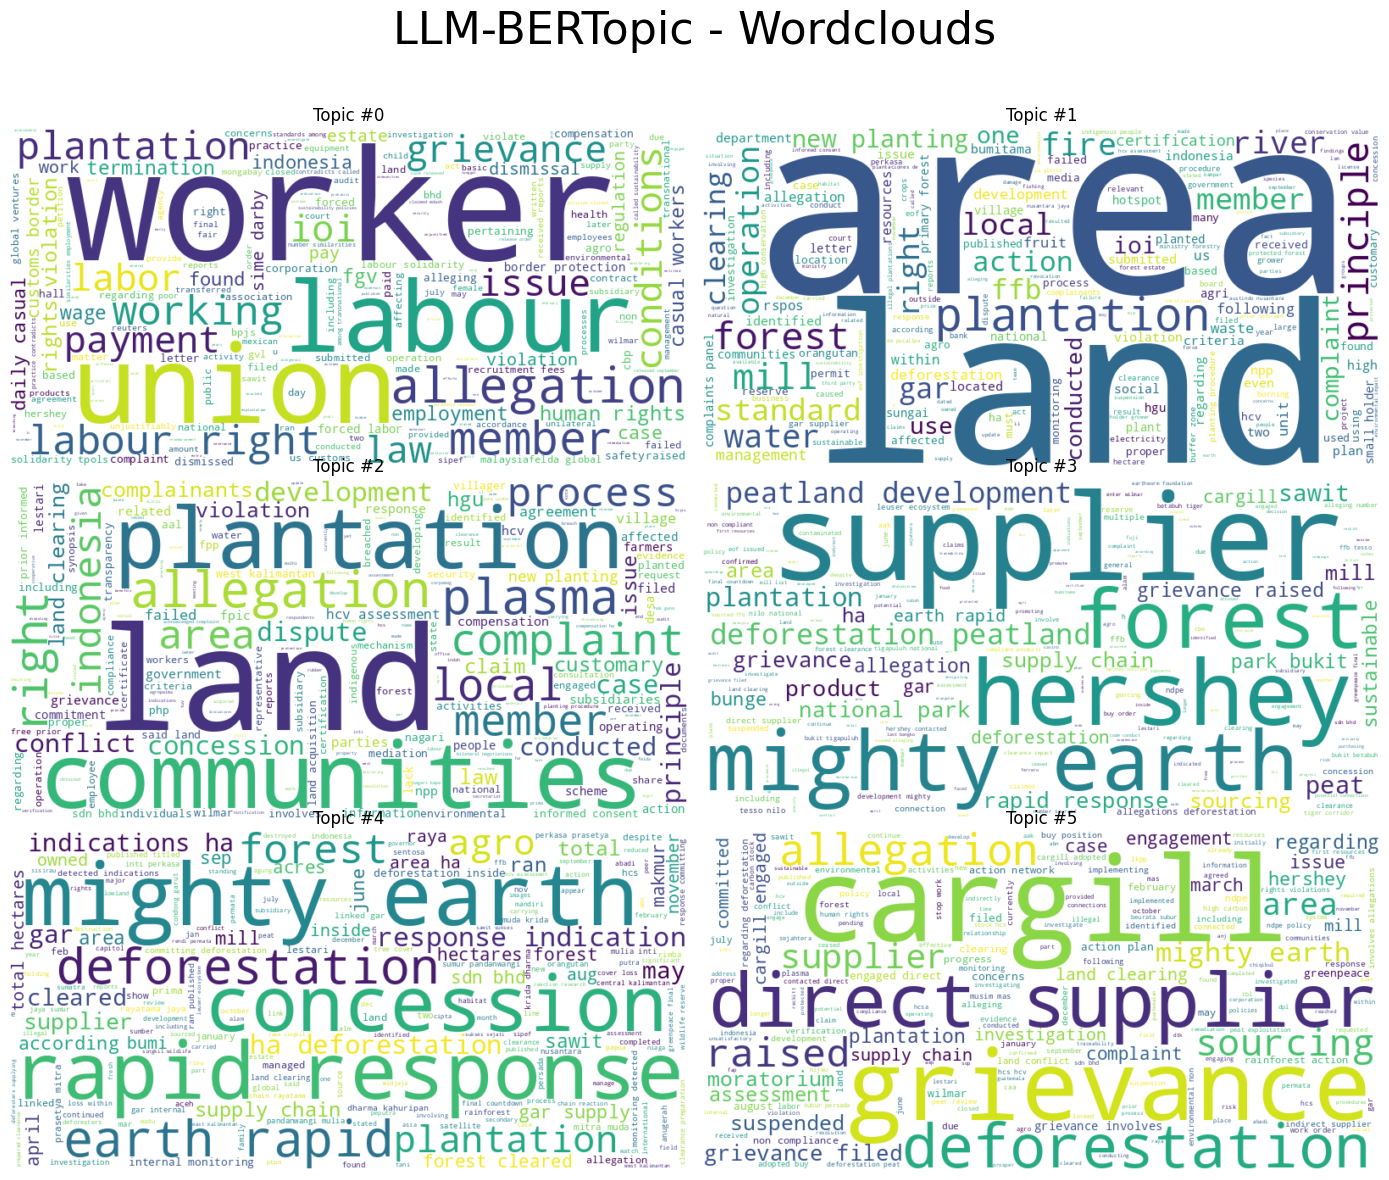

In [23]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=6)

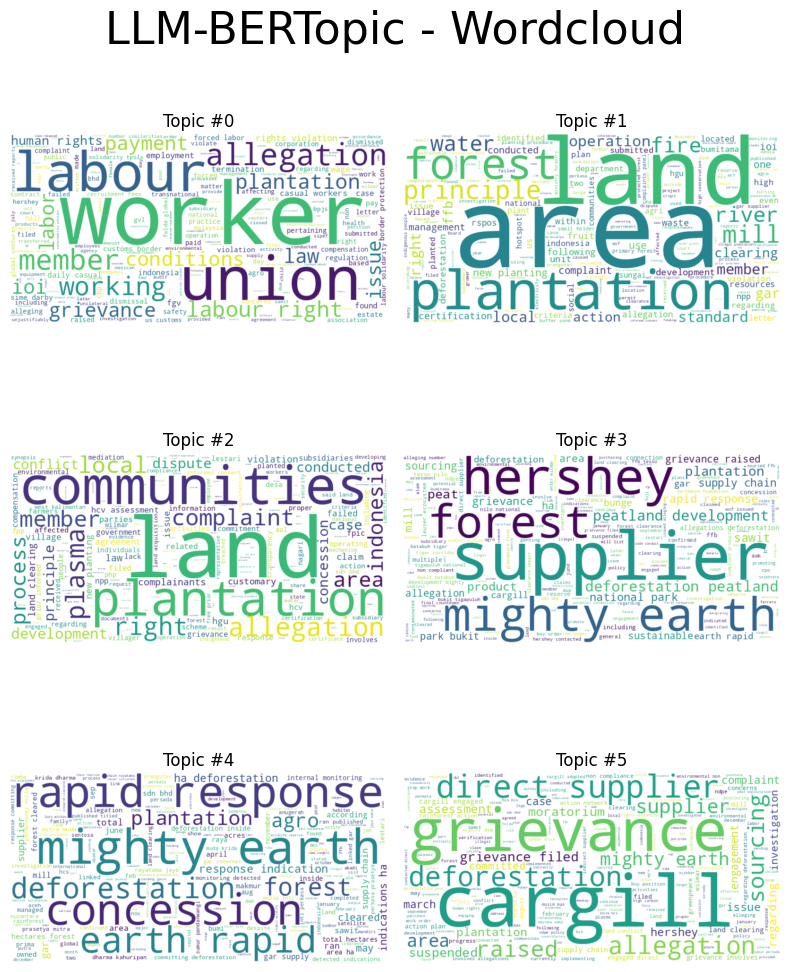

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(8, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32, y=0.9)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordcloud', n_topics=6)

## Dominant Topic Frequency

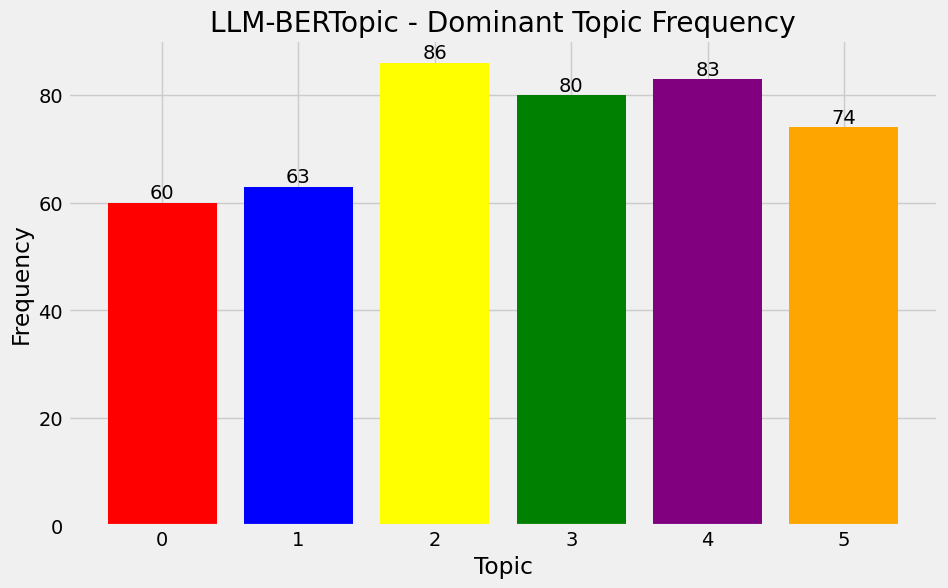

In [25]:
plt.style.use('fivethirtyeight')

# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['Document_Num']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [26]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

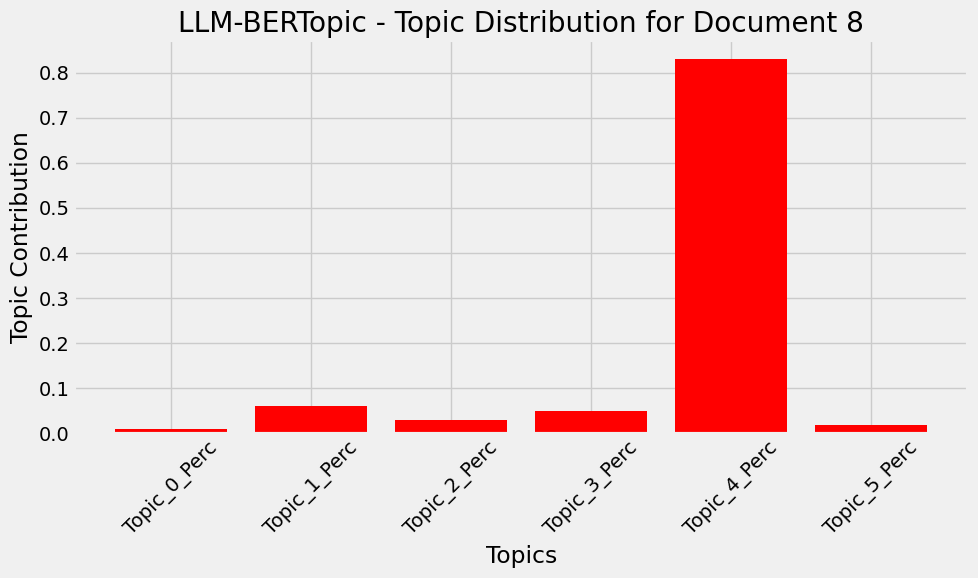

In [27]:
doc_number = 8    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Overall Dominant Topic % Share

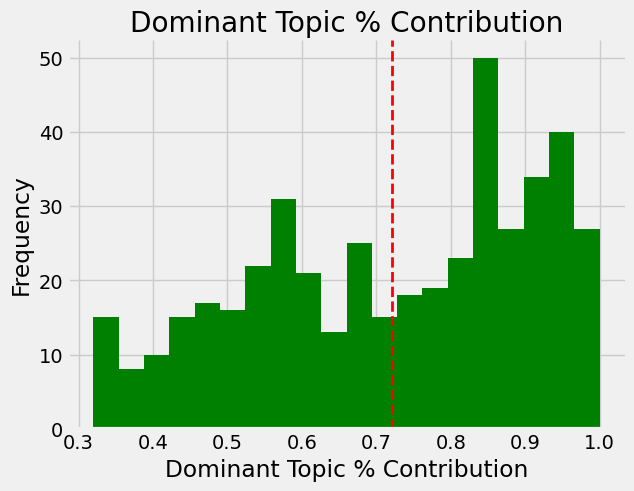

In [28]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)

    # Add Mean line
    mean_value = dominant_topic_df['Topic_%_Contrib'].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Scoring Methods

## Topic Coherence Score

In [29]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


Topic Coherence: 0.5659345562939541


## Topic Diversity

In [30]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.8


## Silhouette Score

In [31]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.04777055


## Davies-Bouldin Index

In [32]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 3.960707303631556


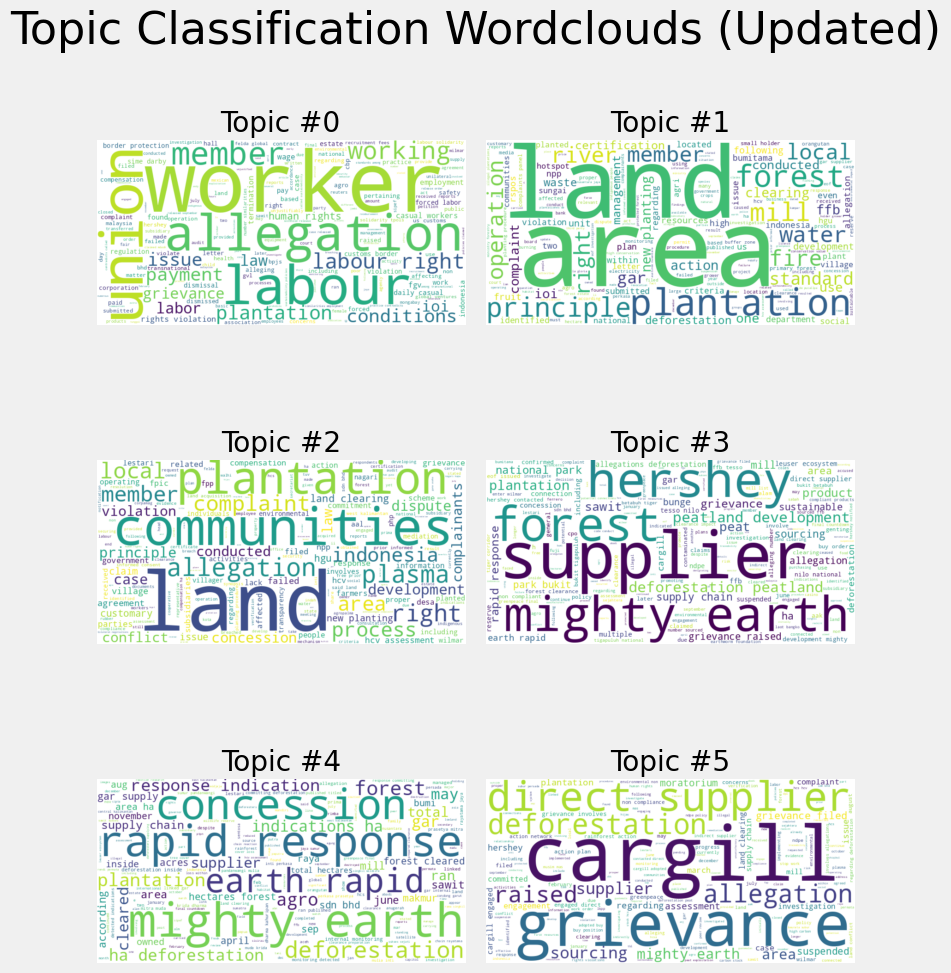

In [33]:
dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds (Updated)', n_topics=number_of_topics)

In [34]:
bertopic_model.visualize_hierarchy()

In [35]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 5/5 [00:00<00:00, 203.13it/s]


In [36]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)

#Undersampling

In [37]:
#undersampled_df = (
#    dominant_topic_df
#    .groupby('Dominant_Topic', group_keys=False)
#    .apply(lambda x: x.loc[x.sample(n=min(len(x), 40), random_state=42).index])
#    .reset_index(drop=True)
#)

/tmp/ipython-input-3140033528.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [38]:
#undersampled_df

In [39]:
#undersampled_df.to_csv('undersampled_by_topic.csv', index=False)

#from google.colab import files
#files.download('undersampled_by_topic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>